# Introduction

## Background
The dataset consists of many different types of macromolecules of biological signifiance. The majority of the data records are of proteins. With DNA being the precursor to RNA, which when translated, proteins are the biomolecules that are directly interacting in biological pathways and cycles. Proteins are usually centered around one or a few job which is defined by their family type. For example, we can have a protein that is from a Hydrolase group, which focuses on catalyzing hydrolysis (breaking bonds by adding water) in order to help promote destruction of chains of proteins, or other molecules. Another example would be a protein that is a transport protein, which allows other molecules such as sucrose, fructose, or even water come in and outside of the cell. 

## Goals
With these proteins having different family types, a question arises if it's possible to determine a protein's family type based on sequence. There are notable search engines such as BLAST which has this capability, but it'd be interesting to see if a machine learning approach can do a good job in classifying a protein's family based on the protein sequence.

### 1). Import Dataset
To begin, the libraries and datasets are loaded. Since the sequence is of a type string, this appears to be a good opporunity to try using a CountVectorizer -- a feature extractor that is usually used with NLP machine learning models.

In [1]:
# 1). ----- Import Libraries and Datasets ------

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Import Datasets
df_seq = pd.read_csv('data/pdb_data_seq.csv')
df_char = pd.read_csv('data/pdb_data_no_dups.csv')

print('Datasets have been loaded...')

Datasets have been loaded...


### 2) Filter and Process Data
With the data loaded into two seperate pandas dataframes, a filter, project, and a join must be performed to get the data together. A good library here to check out is the dfply, which is similar to the dplyr library from R. Nevertheless, pandas offers a way to perform these SQL-like commands. Begin by first filtering the datasets where the classification is equal to 'Protein', followed by removing all other variables  other than structureId and sequence for the data_seq_csv, and structureId and classification in the no_dups dataset.

In [2]:
# 2). ----- Filter and Process Dataset ------

# Filter for only proteins
protein_char = df_char[df_char.macromoleculeType == 'Protein']
protein_seq = df_seq[df_seq.macromoleculeType == 'Protein']

# Select only necessary variables to join
protein_char = protein_char[['structureId','classification']]
protein_seq = protein_seq[['structureId','sequence']]
protein_seq.head()



,structureId,sequence
4,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [3]:
protein_char.head()

,structureId,classification
2,101M,OXYGEN TRANSPORT
4,102L,HYDROLASE(O-GLYCOSYL)
5,102M,OXYGEN TRANSPORT
7,103L,HYDROLASE(O-GLYCOSYL)
8,103M,OXYGEN TRANSPORT


The protein_seq correctly contains proteins as different sequences start with Methoinine, as well as sequences containing more letters than 'ACTG'. We can now perform a join using structureId as the index. We'll utilize pandas 'join' method. To do this, we have to set the index for each dataframe to be 'structureId'. 

In [4]:
# Join two datasets on structureId
model_f = protein_char.set_index('structureId').join(protein_seq.set_index('structureId'))
model_f.head()

,classification,sequence
structureId,,
101M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
102L,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
102M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
103L,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
103M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [5]:
print('%d is the number of rows in the joined dataset' %model_f.shape[0])

346325 is the number of rows in the joined dataset


The two dataframes have officially been joined into one with 346,325 proteins. The data processing is not finished as it's important to take a look at the misingness associated with the columns.

In [6]:
# Check NA counts
model_f.isnull().sum()

classification    1
sequence          3
dtype: int64

With 346,325 proteins, it appears that simply removing missing values is acceptable.

In [7]:
# Drop rows with missing values
model_f = model_f.dropna()
print('%d is the number of proteins that have a classification and sequence' %model_f.shape[0])

346321 is the number of proteins that have a classification and sequence


Lastly, it's important to look at the types of family groups that clasification can be.

HYDROLASE                            46336
TRANSFERASE                          36424
OXIDOREDUCTASE                       34321
IMMUNE SYSTEM                        15615
LYASE                                11682
                                     ...  
STRUCTURAL PROTEIN, CELL CYCLE           1
KINASE (GLYCOGEN METABOLISM)             1
SURFACE GLYCOPROTEIN                     1
IMMUNE SYSTEM,HYDROLASE INHIBITOR        1
antimicrobial                            1
Name: classification, Length: 4468, dtype: int64


C:\Users\Bumba\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


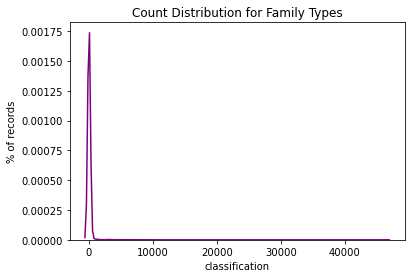

In [8]:
# Look at classification type counts
counts = model_f.classification.value_counts()
print(counts)

#plot counts
plt.figure()
sns.distplot(counts, hist = False, color = 'purple')
plt.title('Count Distribution for Family Types')
plt.ylabel('% of records')
plt.show()

There appears to be a wide distribution of counts for family types. It may be a good idea to filter for having a certain amount of recordes that are of a specific family type. 1,000 seems like a solid number that will allow a machine learning model to learn a pattern for a specific class.

In [9]:
# Get classification types where counts are over 1000
types = np.asarray(counts[(counts > 1000)].index)

# Filter dataset's records for classification types > 1000
data = model_f[model_f.classification.isin(types)]

print(types)
print('%d is the number of records in the final filtered dataset' %data.shape[0])

['HYDROLASE' 'TRANSFERASE' 'OXIDOREDUCTASE' 'IMMUNE SYSTEM' 'LYASE'
 'HYDROLASE/HYDROLASE INHIBITOR' 'TRANSCRIPTION' 'VIRAL PROTEIN'
 'TRANSPORT PROTEIN' 'VIRUS' 'SIGNALING PROTEIN' 'ISOMERASE' 'LIGASE'
 'MEMBRANE PROTEIN' 'PROTEIN BINDING' 'STRUCTURAL PROTEIN' 'CHAPERONE'
 'STRUCTURAL GENOMICS, UNKNOWN FUNCTION' 'SUGAR BINDING PROTEIN'
 'DNA BINDING PROTEIN' 'PHOTOSYNTHESIS' 'ELECTRON TRANSPORT'
 'TRANSFERASE/TRANSFERASE INHIBITOR' 'METAL BINDING PROTEIN'
 'CELL ADHESION' 'UNKNOWN FUNCTION' 'PROTEIN TRANSPORT' 'TOXIN'
 'CELL CYCLE' 'RNA BINDING PROTEIN' 'DE NOVO PROTEIN' 'HORMONE'
 'GENE REGULATION' 'OXIDOREDUCTASE/OXIDOREDUCTASE INHIBITOR' 'APOPTOSIS'
 'MOTOR PROTEIN' 'PROTEIN FIBRIL' 'METAL TRANSPORT'
 'VIRAL PROTEIN/IMMUNE SYSTEM' 'CONTRACTILE PROTEIN' 'FLUORESCENT PROTEIN'
 'TRANSLATION' 'BIOSYNTHETIC PROTEIN']
278866 is the number of records in the final filtered dataset


### 3). Train Test Split
After finally filtering the dataset, a split on the data to create a training and testing set must be performed. After splitting the data, it's important to utilize the CountVectorizer to create a dictionary composed from the training dataset. This will extract individual characters or subsets of characters to gain features. An important note about using the CountVectorizer is the specification of the ngram_range. 

In a protein, it's not the individual amino acid in the protein that gives identification to what it's purpose is. There are secondary and tertiary structures that are formed via the bonds of the amino acids in the sequence. Furthermore, different parts of the chain can be more basic, and others can be more acidic, indicating it's important to use features that are larger than just one unit. As a result, using an ngram_range of (4,4) seems to be a legitmate choice for feature extraction. This will extract different subsets that are of length 4 allowing the amino acids to use their neighbors to aid in our classification.

In [10]:
# 3). ----- Train Test Split -----

# Split Data
X_train, X_test,y_train,y_test = train_test_split(data['sequence'], data['classification'], test_size = 0.2, random_state = 1)

# Create a Count Vectorizer to gather the unique elements in sequence
vect = CountVectorizer(analyzer = 'char_wb', ngram_range = (4,4))

# Fit and Transform CountVectorizer
vect.fit(X_train)
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)

#Print a few of the features
print(vect.get_feature_names()[-20:])

['zhhh', 'ziar', 'zigi', 'ziwz', 'zkal', 'zkky', 'zknt', 'zkyh', 'zlik', 'zlzk', 'zpvm', 'zrgd', 'zrvi', 'ztvl', 'ztzk', 'zvbd', 'zvib', 'zvka', 'zwdl', 'zzvb']


### 4). Machine Learning Models

With the features extracted, it's time to use machine learning models. Traditionally a Naive Bayes approach works well for these types of count vectorized features. Adaboost will be used as well for comparison.

In [11]:
# 4). ------ Machine Learning Models ------

# Make a prediction dictionary to store accuracys
prediction = dict()

# Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train_df, y_train)
NB_pred = model.predict(X_test_df)
prediction["MultinomialNB"] = accuracy_score(NB_pred, y_test)
print( prediction['MultinomialNB'])

0.7638505396779861


In [12]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
model.fit(X_train_df,y_train)
ADA_pred = model.predict(X_test_df)
prediction["Adaboost"] = accuracy_score(ADA_pred , y_test)
print(prediction["Adaboost"])

0.18614408147165346


###5). Visualize Metrics
It appears that Naive Bayes does better in classification than Adaboost. A visualization of a confusion matrix and a clasification report for the Navie Bayes prediction can aid in where the model performs poorly.

<AxesSubplot:>

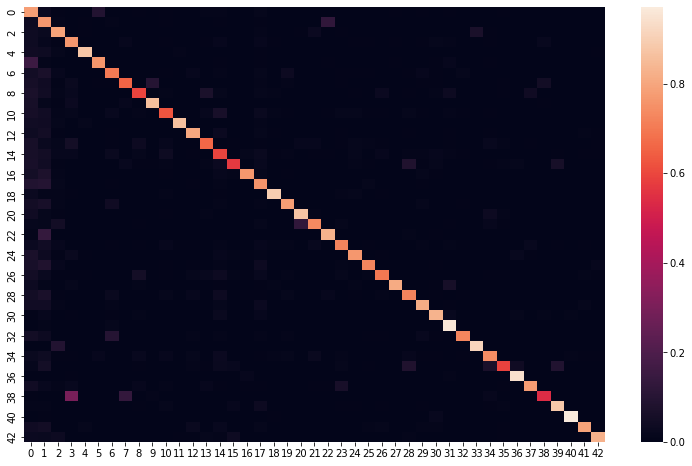

In [13]:
# 5). ----- Plot Confusion Matrix for NB -----

# Plot confusion matrix
conf_mat = confusion_matrix(y_test, NB_pred, labels = types)

#Normalize confusion_matrix
conf_mat = conf_mat.astype('float')/ conf_mat.sum(axis=1)[:, np.newaxis]

# Plot Heat Map
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.heatmap(conf_mat)

The confusion matrix shows label index 3 being misclassified as index 38 quite a bit. Based on the names listed below, it makes sense for these two to be confused.

In [14]:
print(types[3])
print(types[38])

IMMUNE SYSTEM
VIRAL PROTEIN/IMMUNE SYSTEM


Lastly, a matrix of the classification report to show case metrics for each class should be insightful

In [15]:
#Print F1 score metrics
print(classification_report(y_test, NB_pred, target_names = types))

                                         precision    recall  f1-score   support

                              HYDROLASE       0.47      0.74      0.57       250
                            TRANSFERASE       0.60      0.82      0.70       211
                         OXIDOREDUCTASE       0.75      0.77      0.76       589
                          IMMUNE SYSTEM       0.66      0.72      0.69       509
                                  LYASE       0.91      0.76      0.83       859
          HYDROLASE/HYDROLASE INHIBITOR       0.66      0.88      0.76       224
                          TRANSCRIPTION       0.58      0.83      0.68       326
                          VIRAL PROTEIN       0.71      0.78      0.75       622
                      TRANSPORT PROTEIN       0.60      0.74      0.66       601
                                  VIRUS       0.91      0.97      0.94       209
                      SIGNALING PROTEIN       0.71      0.73      0.72       309
                           

### Reasons for Model Error
Proteins in general can be a type of enzyme, or a signaling protein, structural, and various other choices. A lof of proteins tend to share very similar characteristics, as some proteins are meant to bind in similar regions as others. For example, a Hydrolase enzyme and a Hydrolase inhibitor protein are going to have similar structures as they will target very similar areas. This is reflected in the confusion matrix and heat map. Gene regulator proteins will have a similarity to RNA binding proteins, DNA binding proteins, as well as transcription proteins.  The biggest thing to note as well, as the model only uses features of 4 amino acids at most. The possibility of utilizing amino acids of higher degree in theory should be able to create an even higher accuracy.

### Future Work
There is definitely room for improvement for the model. Utilizing factors such as pH, molecular weight, and other components may be able to yield more information on family group. Furthermore, if possible, increase the length of the ngram_range to include more than just 4 characters to allow for higher interaction between the amino acids as reflected in reality

